In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from classes.Architectures import VAEDecoder, VAEEncoder, Discriminator,cVAEDecoder

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor



from torch import distributions as D
from torch.nn.functional import softmax
import wandb

from imutils import paths
import matplotlib.pyplot as plt
import tqdm
from utils.callbacks import *

from sklearn.metrics import classification_report

import os

wandb.login()

"""TO DO: Choose how to update columns in basis (B) matrix.
   Should we include some term in the loss function also?
"""
   



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


'TO DO: Choose how to update columns in basis (B) matrix.\n   Should we include some term in the loss function also?\n'

In [2]:
class VAESIM(nn.Module):


    def __init__(self, input_dim, latent_dim,weight=None, encoder_architecture=[(0,128),[(0,256)]], decoder_architecture=[(0,128),[(0,256)]],n_basis=10):
        """

        :param input_dim: dimension of images
        :param latent_dim: latent_dim

        Attributes
        ----------
        total_loss_tracker: mean of the sum of reconstruction_loss and kl_loss
        reconstruction_loss: mean metrics that are L2 norm between input and outputs
        encoder_architecture: list of tuple, len of list is the number of blocks, [(n_block_res,n_filters)..]
        decoder_architecture: list of tuple, len of list is the number of blocks, [(n_block_res,n_filters)..]
        kl_loss: regularizer loss



        """
        super().__init__()


        self.input_dim=input_dim
        self.latent_dim=latent_dim
        self.encoder_architecture=encoder_architecture
        self.decoder_architecture=decoder_architecture

        if weight is None:
            self.weight=latent_dim/np.prod(input_dim)
        else:
            self.weight=weight

        self.encoder = VAEEncoder( latent_dim=latent_dim,  conv_layer_list=encoder_architecture)
        self.decoder = cVAEDecoder(self.input_dim, latent_dim=latent_dim,  conv_layer_list=decoder_architecture,condition_dim=n_basis)

        self.kl_loss=0
        self.recon_loss=nn.MSELoss()
        self.loss=None

        self.patience=0 #for early stopping
        self.device=None

        self.n_basis=n_basis
        self.spacing=3
        self.basis_mean=torch.arange(0,n_basis)*self.spacing
        
        self.basis=None
        
        
    
    def clustering(self,z):
        """
            @param z: Tensor
            
            returns: tensor of cluster, similarity matrix
        """
        
        
        sim= z@self.basis.type_as(z)
        cl=sim.argmax(-1)
        return cl,sim
        
        
        
        
    def sample(self,z_mean,z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(z_log_var/2.) * epsilon


    
    def reconstruct_and_cluster(self,x):
        
        z_mean,z_log_var = self.encoder(x)
        
        self.q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))

        device=z_mean.get_device()

        # sample z from it
        z = self.q_z.rsample().to(device)
    
        cluster,sim=self.clustering(z)
        x = self.decoder(z,sim)
        
        return x, cluster,sim
    
    
    def forward(self, x):

        
        z_mean,z_log_var = self.encoder(x)
        
        self.q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))

        device=z_mean.get_device()

        
        
        # sample z from it
        z = self.q_z.rsample()

        sim=self.compute_similarity(z)

        self.z=z
        self.z_mean,self.z_log_var=z_mean,z_log_var

        # reference N(0,1)
        ref_mu = torch.zeros(z.shape[0], z.shape[-1])
        ref_sigma = torch.ones(z.shape[0], z.shape[-1])

        self.p_z = D.normal.Normal(ref_mu.to(device), ref_sigma.to(device))
        
        soft_sim=softmax(sim,dim=1)
        x = self.decoder(z,soft_sim)

        return x

    def update_cluster_means(self,z,soft_sim):
        
        """This is the most important function in the code"""
            
        ##map each vector into his cluster
        cl=soft_sim.argmax(-1)
        
        #update the basis matrix columns according to the mean of the vector that belongs to that cluster
        for i in range(self.n_basis):
            
         
            if not torch.isnan(z[cl==i].mean(axis=0)).any():
                
                #Here I check there is no NaN in the mean vector
                
                self.basis[:,i]=z[cl==i].mean(axis=0)

                #print(f"DEBUG -> cl: {cl}")
                #print(f"DEBUG -> z: {z}")
                #print(f"DEBUG -> z[cl=={i}]: {z[cl==i]}")
                             
        
        return cl

    
    def init_clusters(self):
        print("Init basis")
        self.basis=torch.randn(self.latent_dim,self.n_basis).requires_grad_(False)
        
            
            
            
    def compute_similarity(self,z):
        """compute the similarity between each sample and the mean vector of the cluster"""
        
        ## TO DO MATRIX RAPRESENTATION
        
        ### TO DO BETTER INIT
        if  self.basis is None:
            self.init_clusters()
        
        sim= z@self.basis.type_as(z)
        means=self.update_cluster_means(z,softmax(sim))

        
        return sim.detach()
    
    def compute_kl_loss(self):

        #log_qzx = self.q_z.log_prob(self.z)
        #log_pz =  self.p_z.log_prob(self.z)

        # kl
        #kl = -(log_qzx - log_pz)
        #kl = kl.sum(-1)

        kl_div = torch.mean(D.kl_divergence(self.q_z, self.p_z))
        #kl_div=-0.5 * torch.sum(1 + self.z_log_var - self.z_mean.pow(2) - self.z_log_var.exp())
        return self.weight*kl_div

    def compute_reconstruction_loss(self, y_pred, y):
        return self.recon_loss(y_pred, y)

    def compute_loss(self, y_pred, y):
        recon_loss = self.compute_reconstruction_loss(y_pred, y)
        kl_loss = self.compute_kl_loss()

        self.loss = recon_loss + kl_loss

        return self.loss, recon_loss, kl_loss


    def fit(self,train_dataloader,val_dataloader=None,epochs=10,optimizer=None,device="cuda",wandb_log=True,save_model=None,early_stop=None):

        """Main train loop. The logic is all under model.train().
        After the training epoch there is validation loop and some "callbacks" to store weights, save outputs to W&B and visualize it


        """

        self.device=device #set in memory the device type
        model=self

        loss_history = []
        recon_loss_history = []
        kl_loss_history = []

        val_loss_history = []
        val_recon_loss_history = []
        val_kl_loss_history = []

        for epoch in range(epochs):

            # just store loss and accuracy for this epoch

            loss_temp = []
            recon_loss_temp = []
            kl_loss_temp = []

            model.train()
            with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:

                tepoch.set_description(f"Epoch {epoch}")
                for batch in tepoch:
                    # get the data and pass them to device

                    if len(batch)==2:
                        x,y=batch
                    else:
                        x = batch



                    x = x.to(device)

                    # compute the loss
                    x_pred = model(x)

                    loss, recon_loss, kl_loss = model.compute_loss(x_pred, x)

                    # backpropagate
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    loss_temp.append(loss.item())
                    recon_loss_temp.append(recon_loss.item())
                    kl_loss_temp.append(kl_loss.item())

                    tepoch.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

            # store the metrics for epochs
            loss_history.append(np.mean(loss_temp))
            recon_loss_history.append(np.mean(recon_loss_temp))
            kl_loss_history.append(np.mean(kl_loss_temp))

            if wandb_log:
                wandb.log({"loss": loss_history[-1], "recon_loss": recon_loss_history[-1], "kl_loss": kl_loss_history[-1]})

            if val_dataloader is not None:
                val_loss_temp = []
                val_recon_loss_temp = []
                val_kl_loss_temp = []

                model.eval()
                with tqdm.tqdm(val_dataloader, unit="batch") as tepoch:

                    tepoch.set_description(f"Val {epoch}")
                    for batch in tepoch:
                        # get the data and pass them to device

                        if len(batch) == 2:
                            x, y = batch
                        else:
                            x = batch
                        x = x.to(device)

                        # compute the loss
                        x_pred = model(x)

                        val_loss, val_recon_loss, val_kl_loss = model.compute_loss(x_pred, x)

                        # store info
                        val_loss_temp.append(val_loss.item())
                        val_recon_loss_temp.append(val_recon_loss.item())
                        val_kl_loss_temp.append(val_kl_loss.item())

                        tepoch.set_postfix(val_loss=val_loss.item(), val_recon_loss=recon_loss.item(),
                                           val_kl_loss=kl_loss.item())
                    ##handle callbacks



                # store the metrics for validation epochs
                val_loss_history.append(np.mean(val_loss_temp))
                val_recon_loss_history.append(np.mean(val_recon_loss_temp))
                val_kl_loss_history.append(np.mean(val_kl_loss_temp))

                if early_stop is not None:
                    if len(val_loss_history)>2:
                        if val_loss_history[-1]>val_loss_history[-2]:
                            self.patience+=1
                    if self.patience==early_stop:
                        print("[INFO] Early Stopping")
                        break

                if wandb_log:

                    wandb.log({"val_loss": val_loss_history[-1], "val_recon_loss": val_recon_loss_history[-1],
                               "val_kl_loss": val_kl_loss_history[-1]})

                    WandbImagesSIMVAE(self, x,show=True)



                if save_model is not None:
                    SaveModel(self,save_model)

    def encode(self,x):
        return self.encoder(x)

    def decode(self,z):
        return self.decoder(z)


In [4]:
encoder_architecture=[[0,64],[0,128],[0,256]]
decoder_architecture=[[0,64],[0,128]]

n_basis=12
latent_dim=72
input_dim=(1,28,28)



In [5]:
EPOCHS=25
BS=500
INIT_LR=1e-4

config={}
config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


config={"dataset":"MNIST", "type":"VAE","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

wandb.init(project="NeuroGEN_Pytorch",config=config)

## Dataloaders

In [6]:
transform=Compose([ToTensor()])

train_dataset=MNIST('mnist_train', train=True, download=True,
                             transform=transform)
test_dataset=MNIST('mnist_test', train=False, download=True,
                             transform=transform)


In [7]:
train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=True)


## Train Loop

In [8]:
base_path="models/vaesim_mnist"
os.makedirs(base_path,exist_ok=True)

In [9]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [10]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

In [11]:
model=VAESIM(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture,n_basis=n_basis)


optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
model.to(device)
print(f"RUNNING ON {device}")

/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RUNNING ON cuda:0


In [12]:
def mapping(cl,y):
    """map[k]=label so we map the cluster k-th to the label"""
    
    map={}
    
    acc={}
    
    for k in range(n_basis):
        
        v=y[cl==k].mode().values
        map[k]=v
        acc[k]=(y[cl==k]==v).sum()/len(y[cl==k]) 
        
    return map,acc

In [13]:
### PROVe

x,y=next(iter(train_dataloader))

x=x.to(device)

model.init_clusters()

Init basis


In [14]:
check_before=False

if check_before:## forward pass prova
    for epoch in range(EPOCHS):
        print(f"EPOCH: {epoch}")
        for (i,(x,y)) in enumerate(train_dataloader):


            x=x.to(device)


            z_mean,z_log_var = model.encoder(x)


            model.q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))

            device=z_mean.get_device()

            # sample z from it
            z = model.q_z.rsample()

            #z=self.sample(z_mean,z_log_var)

            sim=model.compute_similarity(z)

        #    sim= z@model.basis.type_as(z)

          #  print(f"shapes z: {z.shape} basis: {model.basis.shape} sim: {sim.shape}")

            ##map each vector into his cluster
            cl=sim.argmax(-1)

            #print(cl)

           # print(f"cluster {sim[cl==0].shape} -- {sim[cl==0].mean(axis=0).shape}")

            if i%100==0:
                print(f"ECCOLO {i}\n\n")
                plt.hist(cl.cpu().numpy())
                plt.hist(y.numpy(),alpha=0.6)
                plt.show()

                #aggiungere mapping
                m,a=mapping(cl,y)
                print(m)
                print(a)

            model.z=z
            model.z_mean,model.z_log_var=z_mean,z_log_var

            # reference N(0,1)
            ref_mu = torch.zeros(z.shape[0], z.shape[-1])
            ref_sigma = torch.ones(z.shape[0], z.shape[-1])

            model.p_z = D.normal.Normal(ref_mu.to(device), ref_sigma.to(device))


            soft_sim=softmax(sim,dim=1)
            x2 = model.decoder(z,soft_sim)



            loss, recon_loss, kl_loss = model.compute_loss(x2, x)


            print(f"INDICE {i} - Z {z}")
            print(f"INDICE {i} - SOFT SIM {soft_sim}")

            print(f"INDICE {i} - BASIS {model.basis}")

            print(f"INDICE {i} - X2 {x2}")



            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            #print(model.basis)

            #update the basis matrix columns according to the mean of the vector that belongs to that cluster
            #for i in range(model.n_basis):
            #    model.basis[:,i]=z[cl==i].mean(axis=0) ## GUARDARE QUA!




Epoch 0:   0%|                                                                                                                     | 0/120 [00:00<?, ?batch/s]/tmp/ipykernel_3313085/3278789602.py:162: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  means=self.update_cluster_means(z,softmax(sim))
Val 0: 100%|█████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.78batch/s, val_kl_loss=0.011, val_loss=0.0635, val_recon_loss=0.053]


(500, 28, 28, 1) (100, 28, 28, 3)


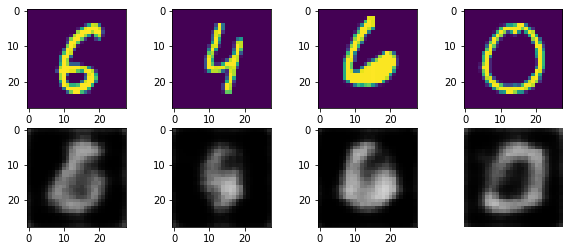

Val 1: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.75batch/s, val_kl_loss=0.0144, val_loss=0.0584, val_recon_loss=0.0438]


(500, 28, 28, 1) (100, 28, 28, 3)


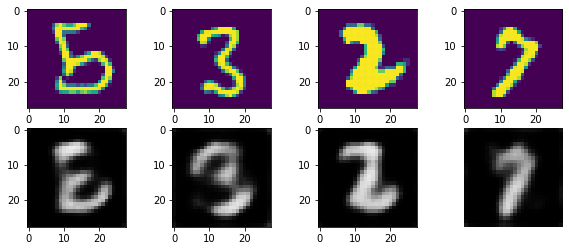

Val 2: 100%|████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.70batch/s, val_kl_loss=0.0146, val_loss=0.056, val_recon_loss=0.0405]


(500, 28, 28, 1) (100, 28, 28, 3)


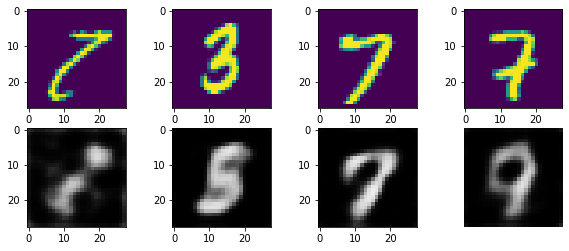

Val 3: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.76batch/s, val_kl_loss=0.0155, val_loss=0.0526, val_recon_loss=0.0374]


(500, 28, 28, 1) (100, 28, 28, 3)


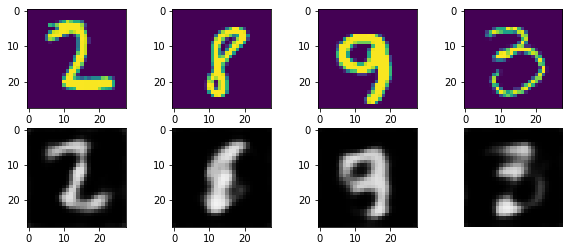

Val 4: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.70batch/s, val_kl_loss=0.0155, val_loss=0.0504, val_recon_loss=0.0344]


(500, 28, 28, 1) (100, 28, 28, 3)


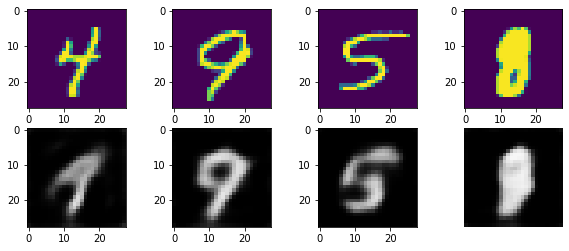

Val 5: 100%|████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.55batch/s, val_kl_loss=0.0156, val_loss=0.0482, val_recon_loss=0.033]


(500, 28, 28, 1) (100, 28, 28, 3)


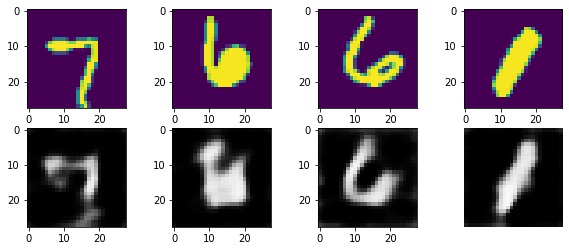

Val 6: 100%|████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.60batch/s, val_kl_loss=0.0157, val_loss=0.0477, val_recon_loss=0.031]


(500, 28, 28, 1) (100, 28, 28, 3)


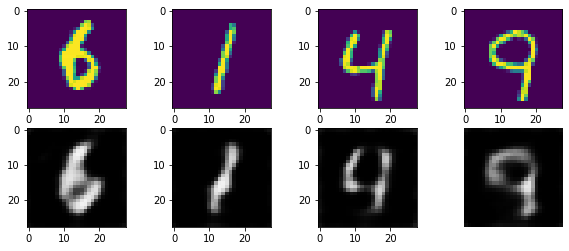

Val 7: 100%|█████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.74batch/s, val_kl_loss=0.0157, val_loss=0.0469, val_recon_loss=0.03]


(500, 28, 28, 1) (100, 28, 28, 3)


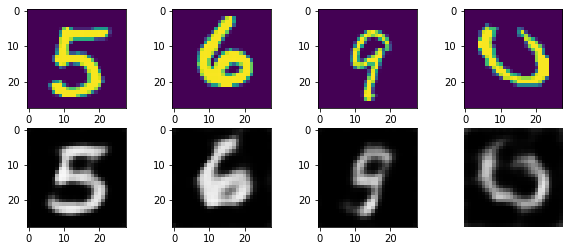

Val 8: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.05batch/s, val_kl_loss=0.0159, val_loss=0.0467, val_recon_loss=0.0294]


(500, 28, 28, 1) (100, 28, 28, 3)


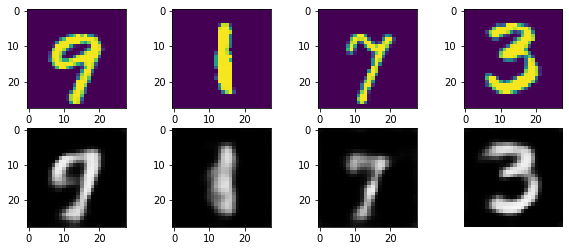

Val 9: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.57batch/s, val_kl_loss=0.0159, val_loss=0.0454, val_recon_loss=0.0292]


(500, 28, 28, 1) (100, 28, 28, 3)


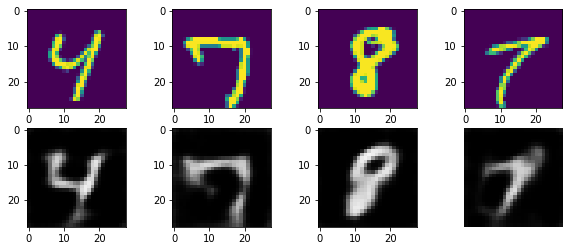

Val 10: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.80batch/s, val_kl_loss=0.0158, val_loss=0.0453, val_recon_loss=0.0284]


(500, 28, 28, 1) (100, 28, 28, 3)


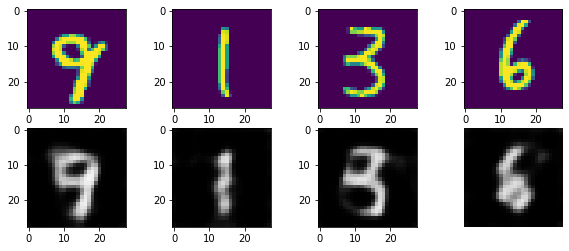

Val 11: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.73batch/s, val_kl_loss=0.0157, val_loss=0.0443, val_recon_loss=0.0282]


(500, 28, 28, 1) (100, 28, 28, 3)


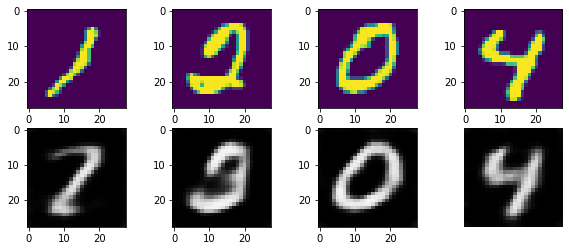

Val 12: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.49batch/s, val_kl_loss=0.0157, val_loss=0.0445, val_recon_loss=0.0279]


(500, 28, 28, 1) (100, 28, 28, 3)


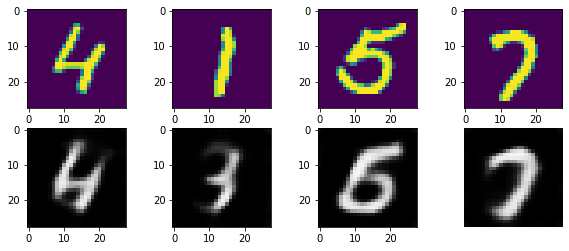

Val 13: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.61batch/s, val_kl_loss=0.0157, val_loss=0.0446, val_recon_loss=0.0276]


(500, 28, 28, 1) (100, 28, 28, 3)


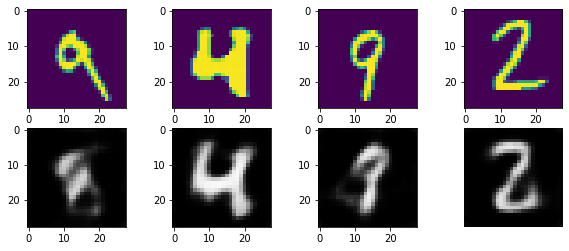

Val 14: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.69batch/s, val_kl_loss=0.0158, val_loss=0.0445, val_recon_loss=0.027]


(500, 28, 28, 1) (100, 28, 28, 3)


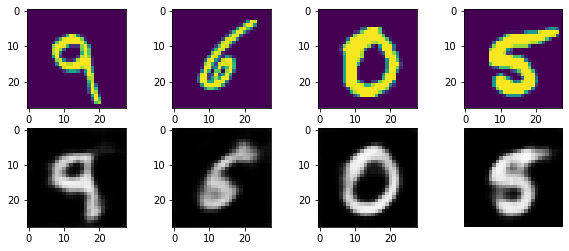

Val 15: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.36batch/s, val_kl_loss=0.0157, val_loss=0.0429, val_recon_loss=0.0271]


(500, 28, 28, 1) (100, 28, 28, 3)


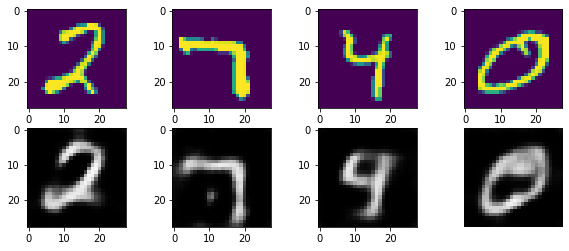

Val 16: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.82batch/s, val_kl_loss=0.0159, val_loss=0.0434, val_recon_loss=0.0267]


(500, 28, 28, 1) (100, 28, 28, 3)


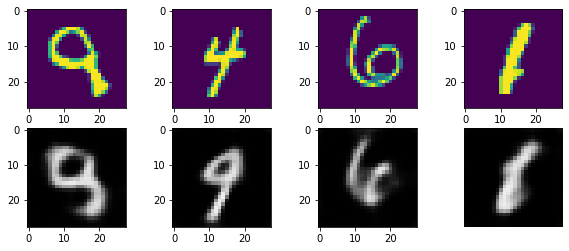

Val 17: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.13batch/s, val_kl_loss=0.0157, val_loss=0.043, val_recon_loss=0.0268]


(500, 28, 28, 1) (100, 28, 28, 3)


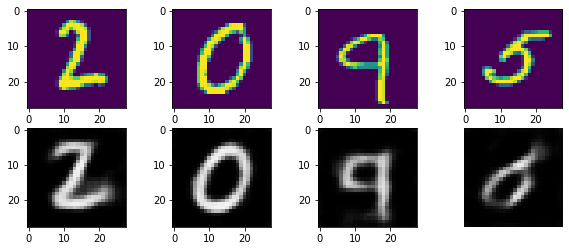

Val 18: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35batch/s, val_kl_loss=0.0159, val_loss=0.0438, val_recon_loss=0.0265]


(500, 28, 28, 1) (100, 28, 28, 3)


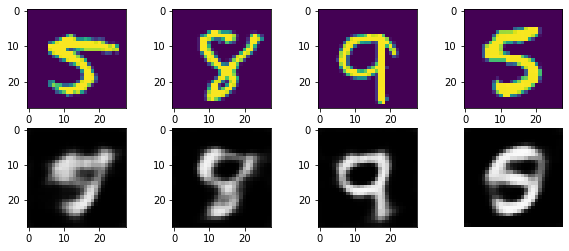

Val 19: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.01batch/s, val_kl_loss=0.0158, val_loss=0.0422, val_recon_loss=0.0265]


(500, 28, 28, 1) (100, 28, 28, 3)


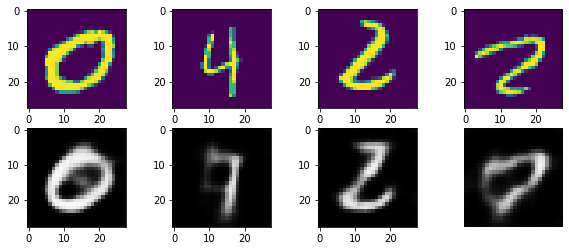

Val 20: 100%|███████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.72batch/s, val_kl_loss=0.016, val_loss=0.0432, val_recon_loss=0.0259]


(500, 28, 28, 1) (100, 28, 28, 3)


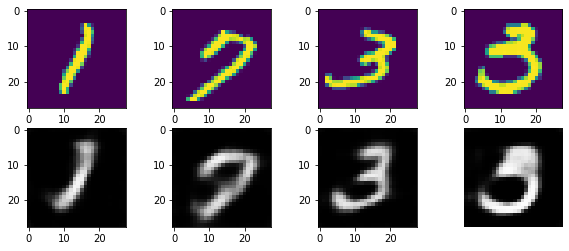

Val 21: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.78batch/s, val_kl_loss=0.0161, val_loss=0.0426, val_recon_loss=0.0256]


(500, 28, 28, 1) (100, 28, 28, 3)


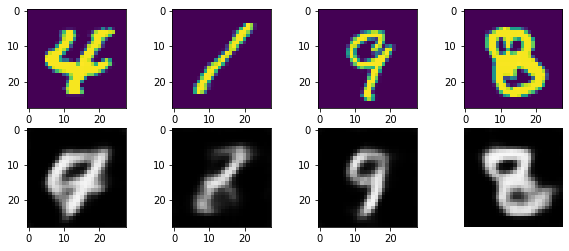

Val 22: 100%|████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.19batch/s, val_kl_loss=0.0162, val_loss=0.042, val_recon_loss=0.025]


(500, 28, 28, 1) (100, 28, 28, 3)


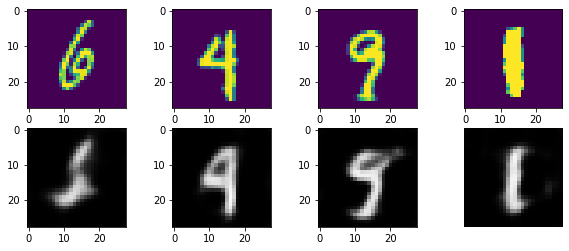

Val 23: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.35batch/s, val_kl_loss=0.0164, val_loss=0.0419, val_recon_loss=0.0252]


(500, 28, 28, 1) (100, 28, 28, 3)


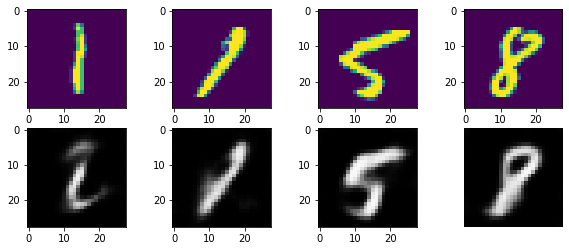

Val 24: 100%|██████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.07batch/s, val_kl_loss=0.0159, val_loss=0.0415, val_recon_loss=0.0258]


(500, 28, 28, 1) (100, 28, 28, 3)


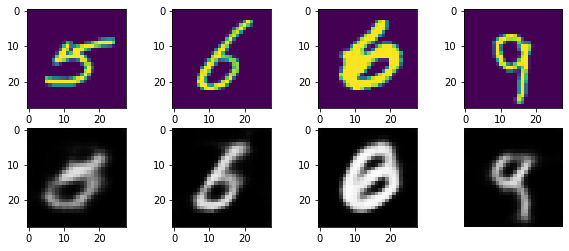

In [15]:

#model.load_state_dict(torch.load(r"models/vae/model.ckp"))

optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
model.to(device)

model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)

In [16]:
torch.save(model.state_dict(), "vaesim_prova1.pt")

torch.save(model.basis,"vaesim_basis.pt")

SIM=model.basis

## Clustering and mappings 


1) Use a subset of the training data to infer the final mappings between clusters and labels
2) Reconstruct the test dataset with the associate labels
3) Inspect the clusters

In [17]:
model.load_state_dict(torch.load("vaesim_prova1.pt"))
model.basis=SIM

In [18]:

with torch.no_grad():

    n_semi=2000



    stack=[]
    labels=[]
    for i,data in enumerate(train_dataset):
        x,y=data
        stack.append(x)
        labels.append(y)
        if i==n_semi-1:
            break


    stack=torch.stack(stack).to(device)
    labels=torch.Tensor(labels)

    ## INFER THE MAPPINGS

    z_mean,z_log_var = model.encoder(stack)

    model.q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))

    device=z_mean.get_device()

    # sample z from it
    z = model.q_z.rsample()

    #z=self.sample(z_mean,z_log_var)
    
    sim=model.compute_similarity(z)

    #    sim= z@model.basis.type_as(z)

    #  print(f"shapes z: {z.shape} basis: {model.basis.shape} sim: {sim.shape}")

    ##map each vector into his cluster
    cl=sim.argmax(-1)

    mappings,accuracy=mapping(cl,labels)

/tmp/ipykernel_3313085/3278789602.py:162: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  means=self.update_cluster_means(z,softmax(sim))


In [19]:
recon=[]
y_pred=[]
labels=[]
for x,y in tqdm.tqdm(test_dataset):
    
    x_rec,cluster,sim=model.reconstruct_and_cluster(x.unsqueeze(0).to(device))
    y_pred.append(int(mappings[cluster.cpu().numpy()[0]].numpy()))
    labels.append(y)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 472.02it/s]


Text(0.5, 1.0, 'label: 6 - predicted 6')

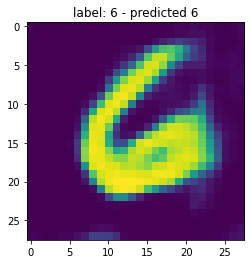

In [20]:
plt.imshow(x_rec.cpu().detach().squeeze(0).permute(1,2,0).numpy())
plt.title(f"label: {y} - predicted {y_pred[-1]}")

In [21]:
print(classification_report(labels, y_pred))

/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      0.75      0.74       980
           1       0.59      0.96      0.73      1135
           2       0.78      0.52      0.62      1032
           3       0.64      0.59      0.61      1010
           4       0.39      0.70      0.50       982
           5       0.37      0.31      0.34       892
           6       0.56      0.81      0.66       958
           7       0.55      0.51      0.53      1028
           8       0.47      0.32      0.38       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.55     10000
   macro avg       0.51      0.55      0.51     10000
weighted avg       0.51      0.55      0.52     10000



/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
mappings

{0: tensor(4.),
 1: tensor(6.),
 2: tensor(5.),
 3: tensor(3.),
 4: tensor(2.),
 5: tensor(8.),
 6: tensor(1.),
 7: tensor(4.),
 8: tensor(1.),
 9: tensor(6.),
 10: tensor(7.),
 11: tensor(0.)}

## Check prototypes

In [29]:
z=model.basis.T.to(device)

In [30]:
cluster,sim=model.clustering(z)
x = model.decoder(z,sim)


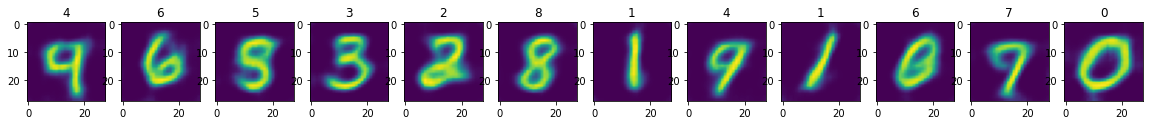

In [40]:
fig, axs= plt.subplots(1,n_basis,figsize=(20,10))

for i,ax in enumerate(axs.ravel()):
    ax.imshow(x[i].cpu().detach().permute(1,2,0).numpy())
    ax.set_title(int(mappings[i].numpy()))